<a href="https://colab.research.google.com/github/Megaptera666/small-projects/blob/master/Working%20through%20Ch1%20of%20Bayesian%20for%20Hackers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original code and explanation at:
https://colab.research.google.com/drive/1hl5BeH-HYApBlPKkH87e_4BHUtBYZDoL#scrollTo=YBCXrK9gj8Gx

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('fivethirtyeight')
tfd=tfp.distributions

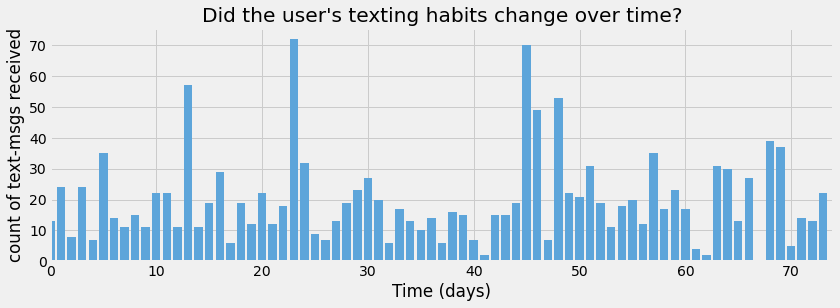

In [0]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)

n_count_data=tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

#Visualize the data 
plt.figure(figsize=(12.5,4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data[0].numpy());


In [0]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
  alpha = (1./tf.reduce_mean(count_data))
  rv_lambda_1=tfd.Exponential(rate=alpha)
  rv_lambda_2 = tfd.Exponential(rate=alpha)
  rv_tau = tfd.Uniform()

  lambda_ = tf.gather(
      [lambda_1,lambda_2],
      indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32),dtype=tf.int32))
  rv_observation = tfd.Poisson(rate=lambda_)

  return (
      rv_lambda_1.log_prob(lambda_1)
      + rv_lambda_2.log_prob(lambda_2)
      + rv_tau.log_prob(tau)
      + tf.reduce_sum(rv_observation.log_prob(count_data))
  )

#Define a closure function
def unnormalized_log_posterior(lambda1, lambda2, tau):
  return joint_log_prob(count_data, lambda1, lambda2, tau)


In [0]:
@tf.function(autograph=False)
def graph_sample_chain(*args,**Kwargs):
  return tfp.mcmc.sample_chain(*args,**Kwargs)

num_burnin_steps = 5000
num_results = 20000

#set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([],dtype=tf.float32, name="init_tau"),
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors= [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_posterior,
        num_leapfrog_steps=2,
        step_size=step_size,
        state_gradients_are_stopped=True),
      bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

    
# Sample from the chain
[ 
  lambda_1_samples,
  lambda_2_samples,
  posterior_tau
], kernel_results = graph_sample_chain(
    num_results= num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel=kernel)

tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data), dtype=tf.float32))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


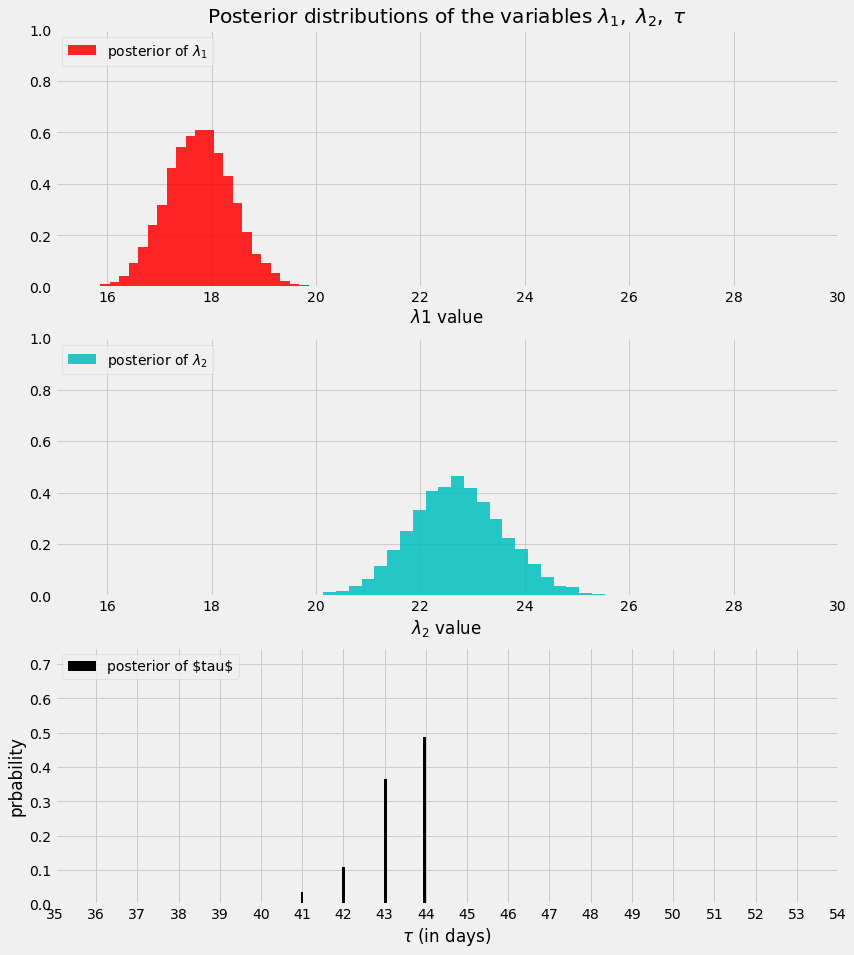

In [0]:
plt.figure(figsize=(12.5,15))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color='r', density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15,30])
plt.xlabel(r"$\lambda1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype="stepfilled", bins=30, alpha= 0.85,
         label=r"posterior of $\lambda_2$", color='c', density=True)
plt.legend(loc="upper left")
plt.xlim ([15,30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data[0], alpha=1,
         label=r"posterior of \$tau$",
         color='k', weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.ylim([0,.75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"prbability");

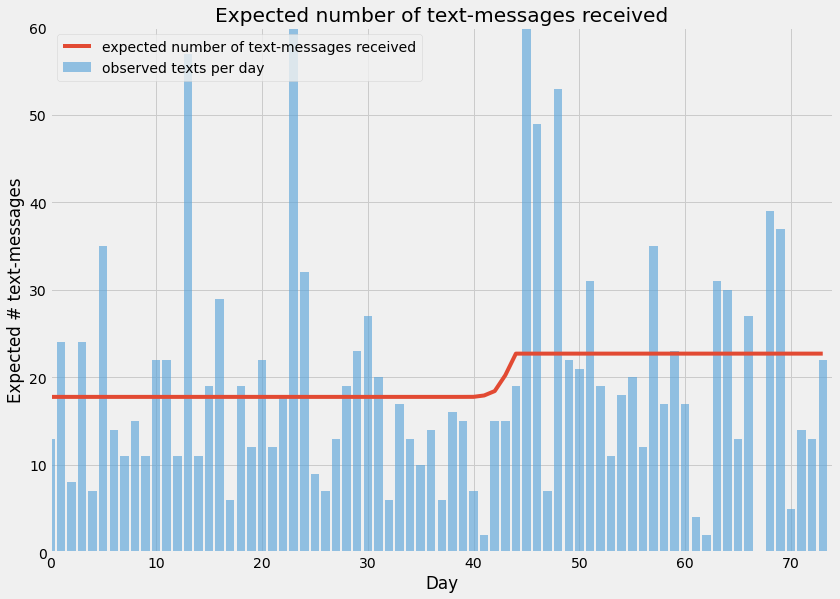

In [0]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_texts_per_day= tf.zeros(N_,n_count_data.shape[0]) 

plt.figure(figsize=(12.5, 9))

day_range = tf.range(0,n_count_data[0], delta=1, dtype=tf.int32)

#expand from shape 74 to (10000,74)
day_range = tf.expand_dims(day_range,0)
day_range = tf.tile(day_range, tf.constant([N_,1]))

# expand from shape of 10000 to 10000,74
tau_samples_per_day = tf.expand_dims(tau_samples,0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day,tf.constant([day_range.shape[1],1])))

tau_samples_per_day = tf.cast(tau_samples_per_day, dtype=tf.int32)
#ix_day is (10000,74) tensor where axis=0 is number of samples, axis=1 is day. each value is true if sampleXday value is < tau_sample value
ix_day = day_range < tau_samples_per_day


lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day,tf.constant([day_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((tf.reduce_sum(lambda_1_samples_per_day*tf.cast(ix_day,dtype=tf.float32),axis=0) + tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~ix_day,dtype=tf.float32),axis=0))/N_)

plt.plot(range(n_count_data[0]), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data.numpy()[0])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [0]:
ix_day

n_count_data

day_range
N_

#plt.plot(range(n_count_data[0]), tf.transpose(tau_samples_per_day), lw=4, color="#E24A33",
#         label="tau samples per day")

#plt.hist(tau_samples_per_day[0], bins=n_count_data[0], alpha=1)
         #label=r"posterior of \$tau$",
        # color='k', weights=w, rwidth=2.)

20000

# Now try using PyMC